<a href="https://colab.research.google.com/github/sharmayash105/E-CELL-IITH-Home/blob/main/CAE_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries required

In [ ]:
!pip install hyperopt

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import numpy as np
from hyperopt import fmin, tpe, hp, Trials
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt

## Dataset and model preparation

#### Here, padding is applied to the train and test dataset to match the shapes of input and output image. We require the dimension to not have odd number as its factor.

In [ ]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

new_x_train = np.zeros((len(x_train), 32, 32, 1))
new_x_train =  tf.keras.layers.ZeroPadding2D(padding=2)(x_train)
new_x_test = np.zeros((len(x_test), 32, 32, 1))
new_x_test =  tf.keras.layers.ZeroPadding2D(padding=2)(x_test)

input_img = Input(shape=(32, 32, 1))

def model_design(params):
    num_layers = int(params['num_layers'])
    learning_rate = params['learning_rate']
    num_filters = int(params['num_filters'])
    activation = params['activation']

    # Encoder
    x = input_img
    for _ in range(num_layers):
        x = Conv2D(num_filters, (3, 3), activation=activation, padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        print('Debug: Encoder:', x.shape)

    encoded = x

    # Decoder
    for _ in range(num_layers):
        x = Conv2D(num_filters, (3, 3), activation=activation, padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        print('Debug: Decoder:', x.shape)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy')

    return autoencoder

# training and validation sets
x_train, x_val = train_test_split(new_x_train, test_size=0.2, random_state=42)

# Hyperparameter search space
space = {
    'num_layers': hp.quniform('num_layers', 1, 4, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.2)),
    'num_filters': hp.quniform('num_filters', 8, 24, 1),
    'activation': hp.choice('activation', ['relu', 'sigmoid', 'linear'])
}

# Objective function to minimize (Mean Squared Error)
def objective(params):
    model = model_design(params)
    model.fit(new_x_train, new_x_train, epochs=8, batch_size=32, verbose=0)
    x_pred = model.predict(new_x_test)
    x_pred = np.array(x_pred)
    mse = mean_squared_error(np.array(new_x_test).flatten(), np.array(x_pred).flatten())

    return mse

#### Max_Evals: The max_eval parameter is simply the maximum number of optimization runs. (e.g. If max_evals = 5, Hyperas will choose a different combination of hyperparameters 5 times and run each combination for the amount of epochs you chose) It will go through one combination of hyperparamets for each max_eval. The best combination of hyperparameters will be after finishing all evaluations you gave in max_eval parameter.

#### Trials: In Hyperopt, the Trials object is used to store information about each evaluation, such as the hyperparameters and corresponding objective function values.

In [ ]:
# Number of evaluations
max_evals_value = 12

# Trials object to keep track of the evaluations
trials = Trials()

# Bayesian optimization to find the best hyperparameters
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=max_evals_value, verbose=1, trials=trials)

print("Best Hyperparameters:", best)

# Accessing information about the evaluations
for t in trials.trials:
    print("Trial:", t['tid'])
    print("Hyperparameters:", t['misc']['vals'])
    print("Loss:", t['result']['loss'])
    print("=" * 50)

Debug: Encoder:
(None, 16, 16, 10)
Debug: Encoder:
(None, 8, 8, 10)
Debug: Encoder:
(None, 4, 4, 10)
Debug: Encoder:
(None, 2, 2, 10)
Debug: Decoder:
(None, 4, 4, 10)
Debug: Decoder:
(None, 8, 8, 10)
Debug: Decoder:
(None, 16, 16, 10)
Debug: Decoder:
(None, 32, 32, 10)
313/313 [==============================] - 6s 18ms/step

Debug: Encoder:
(None, 16, 16, 18)
Debug: Encoder:
(None, 8, 8, 18)
Debug: Decoder:
(None, 16, 16, 18)
Debug: Decoder:
(None, 32, 32, 18)
313/313 [==============================] - 6s 21ms/step

Debug: Encoder:
(None, 16, 16, 15)
Debug: Encoder:
(None, 8, 8, 15)
Debug: Decoder:
(None, 16, 16, 15)
Debug: Decoder:
(None, 32, 32, 15)
313/313 [==============================] - 6s 20ms/step

Debug: Encoder:
(None, 16, 16, 14)
Debug: Encoder:
(None, 8, 8, 14)
Debug: Decoder:
(None, 16, 16, 14)
Debug: Decoder:
(None, 32, 32, 14)
313/313 [==============================] - 7s 21ms/step

Debug: Encoder:
(None, 16, 16, 17)
Debug: Encoder:
(None, 8, 8, 17)
Debug: Decoder:
(Non

## Best hyperparameter testing

In [ ]:
best['activation'] = 'sigmoid'
best_model = model_design(best)
history = best_model.fit(new_x_train, new_x_train, epochs=10, batch_size=32,verbose=1,validation_data=(x_val, x_val))

Debug: Encoder: (None, 16, 16, 22)
Debug: Decoder: (None, 32, 32, 22)
Epoch 1/10
1875/1875 [==============================] - 131s 69ms/step - loss: 0.0605 - val_loss: 0.0489
Epoch 2/10
1875/1875 [==============================] - 129s 69ms/step - loss: 0.0484 - val_loss: 0.0481
Epoch 3/10
1875/1875 [==============================] - 129s 69ms/step - loss: 0.0477 - val_loss: 0.0474
Epoch 4/10
1875/1875 [==============================] - 129s 69ms/step - loss: 0.0471 - val_loss: 0.0469
Epoch 5/10
1875/1875 [==============================] - 129s 69ms/step - loss: 0.0467 - val_loss: 0.0466
Epoch 6/10
1875/1875 [==============================] - 129s 69ms/step - loss: 0.0465 - val_loss: 0.0464
Epoch 7/10
1875/1875 [==============================] - 128s 68ms/step - loss: 0.0463 - val_loss: 0.0462
Epoch 8/10
1875/1875 [==============================] - 128s 68ms/step - loss: 0.0462 - val_loss: 0.0462
Epoch 9/10
1875/1875 [==============================] - 129s 69ms/step - loss: 0.0461 - va

In [ ]:
print(best_model.history.history)  # Print the available keys in the history

training_loss = best_model.history.history['loss']
test_loss = best_model.history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

{}


KeyError: ignored

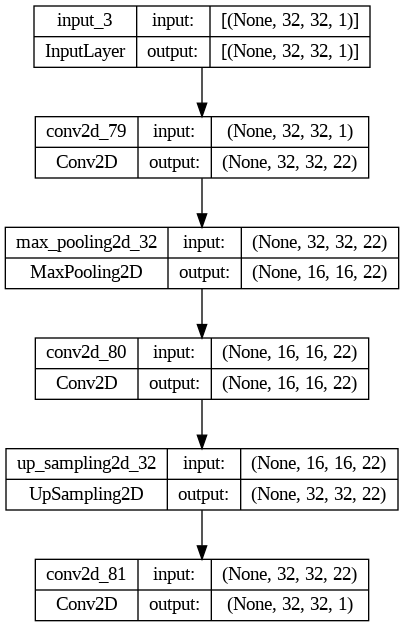

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(best_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
 tf.experimental.numpy.experimental_enable_numpy_behavior()

1/1 [==============================] - 0s 128ms/step


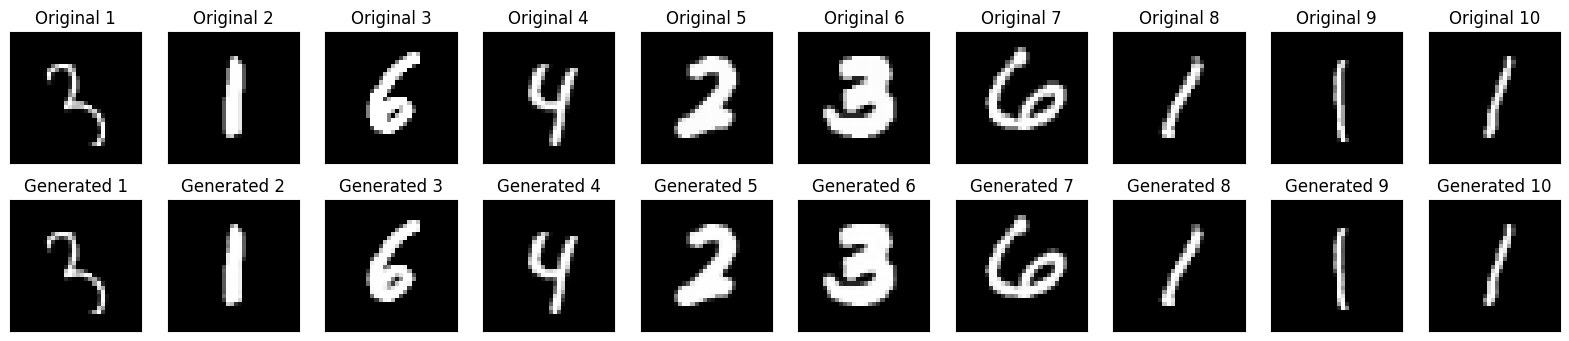

In [ ]:
# Original images
original_images = new_x_test[195:205]

# Generated images
generated_images = best_model.predict(original_images)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # Plotting original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_images[i].reshape(32, 32), cmap='gray')
    plt.title(f'Original {i + 1}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Plotting generated image
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(generated_images[i].reshape(32, 32), cmap='gray')
    plt.title(f'Generated {i + 1}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()